<h1>A Temporal Gaussian Noise Model for Equalization-enhanced Phase Noise (EEPN)</h1>
In this script, we provide an implementation of our proposed temporal Gaussian noise model for equalization-enhanced phase noise model, which we presented at the European Conference on Optical Communication (ECOC) in Copenhagen in October 2025:

B. Geiger, F. Buchali, V. Aref, and L. Schmalen, "A Temporal Gaussian Noise Model for Equalization-enhanced Phase Noise" In Proc. European Conference on Optical Communication (ECOC), Copenhagen, Denmark, 2025, Tu01.05.3, https://arxiv.org/abs/2507.08470

In particular, we compare our temporal Gaussian noise model to a full system simulation and show that we can obtain and generate the same system performance with less code, less computational complexity and much faster.
**Possible applications of our model include:**
<ul>
  <li>Accurate and low-complexity performance prediction</li>
  <li>Baseline for EEPN mitigation algorithms</li>
  <li>Modeling impaired links (using our model in a generative manner)</li>
</ul> 

In [1]:
# Imports
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import upsample, rrc_pulse, qammod, ecdf, movmean, movvar

### Parameters

In [2]:
symbol_rate = 130e9;                    #  Symbol Rate in Baud
linewidth = 210e3;                      #  Linewidth of the local oscillator (LO) in Hertz
fiber_length = 1900;                    #  Fiber length in km

mod_order = 16;                         #  Modulation format order
oversampling_factor = 2;                #  Oversampling factor

RRC_roll_off = 0.01;                    #  RRC Roll-off factor (Pulse shaping & matched filter)
RRC_span = 100;                         #  RRC span (Pulse shaping & matched filter)

snr = 13;                               #  Signal-to-noise ratio in dB

num_transmission_symbols = 1e7;         #  Number of modulation symbols to transmit

D_cd = 18.957e-12/(1e-9);               #  Chromatic Dispersiopn Parameter in s/(km*m)
wavelength = 1.55e-6;                   #  Center Wavelength in m
c_0 = 3e8;                              #  Vacuum speed of light in m/s

CPR_window_length = 50;                 #  Window length of the carrier phase recovery (CPR) in symbols: here ideal data-remodulation

block_length_SNR_evaluation = 500;      #  Number of symbols which are used to estimate the SNR after the transmission

t = np.arange(num_transmission_symbols)/symbol_rate; #  Time vector

df = symbol_rate/num_transmission_symbols; #  frequncy resolution
# f = [-num_transmission_symbols*oversampling_factor/2:1:num_transmission_symbols*oversampling_factor/2-1]*df; #  Frequency vector
f = (np.arange(num_transmission_symbols*oversampling_factor)-num_transmission_symbols*oversampling_factor/2)*df

#  Calculate the temporal broadening a pulse due to chromatic dispersion
D = D_cd*fiber_length;                  #  Temporal broadening/accumulated dispersion in ns/nm
Delta_lambda = (wavelength)**2/c_0*symbol_rate; #  Sepctral width in wavelength
Delta_T = D*Delta_lambda;               #  Temporal broadening/accumulated dispersion in s
CD_memory = round((Delta_T*130e9));     #  Temporal broadening/CD memory in samples

discard_symbols_analysis = 2*CD_memory;   #  Number of symobls which are discarded in the analysis at the start and end of a sequence

<h3>LO Phase Noise</h3>
In this script, we model the LO phase noise as a Wiener process. However, here you could also loud your measured LO phase noise realization like we did in our paper or generate any other LO phase realization. Our proposed temporal Gaussian noise model does not make any assumptions about the LO phase noise statistics.

In [3]:
# Variance of the Wiener process
sigma2_LO = 2*np.pi*linewidth*(1/(oversampling_factor*symbol_rate))

# Sample increments
Rx_delta_phi = np.sqrt(sigma2_LO) * np.random.randn(int(num_transmission_symbols*oversampling_factor))

# Calculate LO phase realization
Rx_phi = np.cumsum(Rx_delta_phi) + 2*np.pi*np.random.rand()

<h2>Full System Simulation</h2>
<h3>Transmitter</h3>
In the transmitter, we choose Tx symbols uniformly, upsample and apply a pulse shaping filter

In [4]:
# Generate transmit symbols (integers then map)
Tx_int = np.random.randint(0, mod_order, size=int(num_transmission_symbols))
Tx_symbols = qammod(mod_order, Tx_int)

# Upsample by oversampling_factor
Tx_symbols_up = upsample(Tx_symbols, oversampling_factor)

# RRC pulse shaping
rrcFilter = rrc_pulse(RRC_roll_off, RRC_span, oversampling_factor)

# Apply the pulse shaping filter
Tx_signal = np.convolve(Tx_symbols_up, rrcFilter, mode='same')

### Channel
We pass the transmit signal through a chromatic dispersion (CD) filter and add AWGN to account for amplified spontaneous emission, fiber nonlinearity and transceiver impairments.

In [5]:
# Initialze CD filter
H_cd = np.exp(1j*np.pi*(wavelength**2)/c_0 * D_cd * fiber_length * (f**2))

dispersed_signal = np.fft.ifft(np.fft.ifftshift(H_cd * np.fft.fftshift(np.fft.fft(Tx_signal,norm='ortho'))),norm='ortho')

# Add AWGN at specified SNR (per-symbol, unit power constellation assumed)
system_noise_power = 10**(-snr/10)
noise = (np.sqrt(system_noise_power/2)*np.random.randn(len(Tx_signal)) +
         1j*np.sqrt(system_noise_power/2)*np.random.randn(len(Tx_signal)))
Rx_signal = dispersed_signal + noise

### Receiver
In the receiver, the signal is first impaired by phase noise due to the finite linewidth of the laser. Next, we apply the chromatic dispersion compensation (CDC) filter and matched filter. Then, we downsample and estimate the phase using ideal data remodulation (A. Arnould and A. Ghazisaeidi, “Equalization Enhanced Phase Noise in Coherent Receivers: DSP-Aware Analysis and Shaped Constellations”, Journal of Lightwave Technology, vol. 37, no. 20, pp. 5282–5290, Oct. 2019).

In [6]:
# Apply LO phase noise
Rx_signal_with_phase_noise = Rx_signal * np.exp(1j*Rx_phi)

# CD compensation (apply conjugate H_cd in freq domain)
Y = np.fft.fftshift(np.fft.fft(Rx_signal_with_phase_noise,norm='ortho'))

Rx_signal_cdc = np.fft.ifft(np.fft.ifftshift(Y * np.conj(H_cd)),norm='ortho')

# Matched filter (RRC)
Rx_symbols_up = np.convolve(Rx_signal_cdc, rrcFilter, mode='same')

# Downsample to symbol rate
Rx_symbols = Rx_symbols_up[::oversampling_factor]

# Carrier phase recovery (data-aided with ideal remodulation proxy)
phase_est = np.angle(movmean(np.conj(Tx_symbols) * Rx_symbols, CPR_window_length))
Rx_symbols_CPR = Rx_symbols * np.exp(-1j*phase_est)

# Mean frequency-dependent phase noise (during CD-induced memory)
mean_fd_phase = movmean(Rx_phi[::oversampling_factor], max(1, CD_memory + 1))

<IPython.core.display.Javascript object>


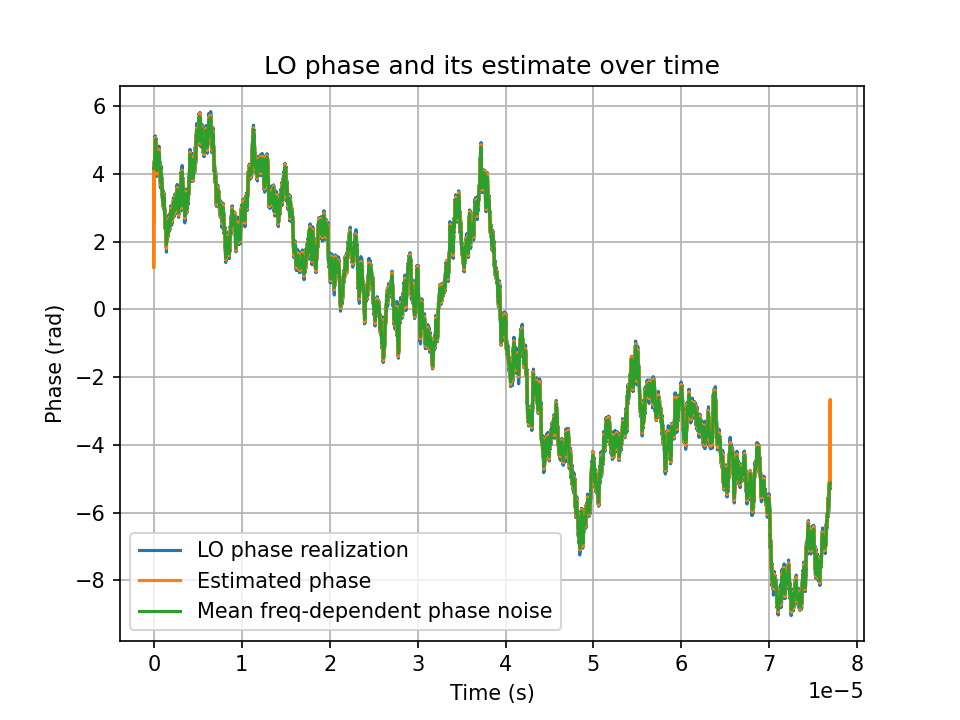

In [7]:
plt.figure()
plt.title("LO phase and its estimate over time")
plt.plot(t, Rx_phi[::oversampling_factor])
plt.plot(t, np.unwrap(phase_est))
plt.plot(t, np.real(mean_fd_phase))
plt.legend(["LO phase realization", "Estimated phase", "Mean freq-dependent phase noise"])
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad)")
plt.grid()

When you zoom in, you can observe that the estimated phase does not longer follow the LO phase noise but the mean frequency-dependent phase noise given by the sliding mean of the LO phase noise.

### Evaluation

In [8]:
sigma_simulation = movvar(Rx_symbols_CPR - Tx_symbols, block_length_SNR_evaluation)

# Discard edges
sigma_simulation = sigma_simulation[discard_symbols_analysis: len(sigma_simulation)-discard_symbols_analysis]

## Temporal Gaussian Noise Model for Equalization-enhanced Phase Noise
In this section, we provide an implementation of our proposed temporal Gaussian noise model

In [9]:
# Calculate the EEPN distortion power
sigma_EEPN = np.real(movvar(Rx_phi[::oversampling_factor], CD_memory + 1))

# Calculate time-varying distortion power
sigma_time_varying = system_noise_power + sigma_EEPN

Comment: We can now either use directly the calculated distortion power for the evaluation (less noisy) or we can use our model in a generative manner to generate noisy received symbols modeling an EEPN-impaired link.

In [10]:
# Sample AWGN from time-varying distortion power and add to transmit signal
Rx_symbols_TGN = Tx_symbols + (np.sqrt(sigma_time_varying/2)*np.random.randn(len(Tx_symbols)) +
         1j*np.sqrt(sigma_time_varying/2)*np.random.randn(len(Tx_symbols)))

### Evaluation

In [11]:
# Cut the directly calculated distortion power
sigma_time_varying = sigma_time_varying[discard_symbols_analysis: len(sigma_time_varying)-discard_symbols_analysis]

# Calculate and cut the distortion power in case the model is used in a generative manner
sigma_TGN = movvar(Rx_symbols_TGN - Tx_symbols, block_length_SNR_evaluation)
sigma_TGN = sigma_TGN[discard_symbols_analysis: len(sigma_TGN)-discard_symbols_analysis]

## Comparison
In this section, we compare the temporal Gaussian noise model to the full-system simulation.

### Illustrative SNR/Variance sequence
###### Please zoom in to see how our model follows the simulation ;)

<IPython.core.display.Javascript object>


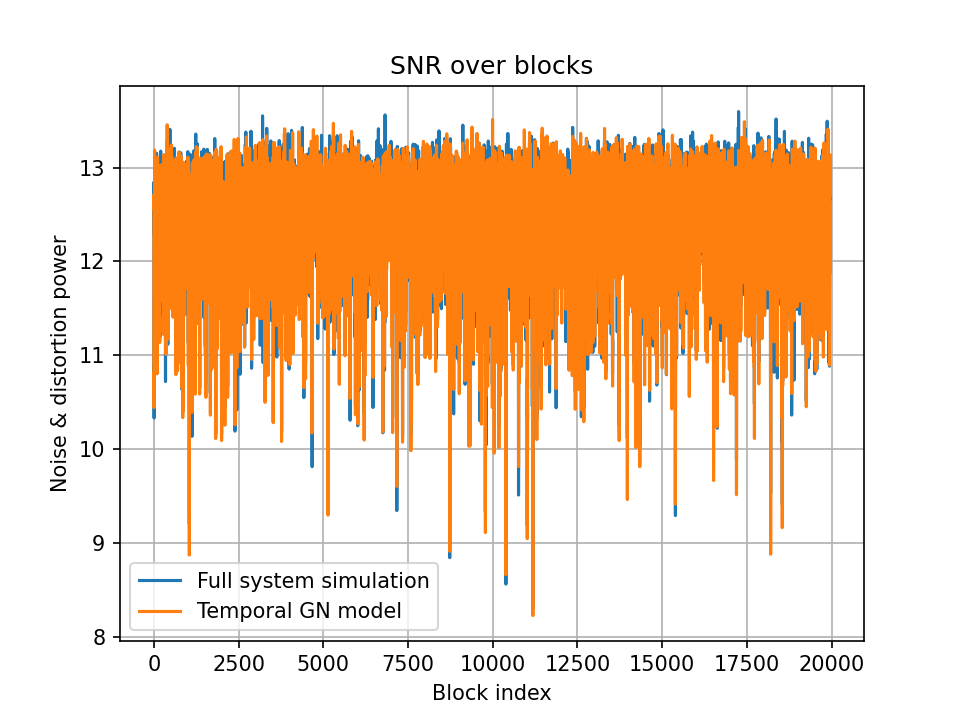

In [12]:
plt.figure()
plt.title("SNR over blocks")
plt.plot(10*np.log10(1/sigma_simulation[::block_length_SNR_evaluation]))
plt.plot(10*np.log10(1/sigma_TGN[::block_length_SNR_evaluation]))
plt.legend(["Full system simulation", "Temporal GN model"])
plt.xlabel("Block index"); plt.ylabel("Noise & distortion power")
plt.grid()

### Statistical Analysis

<IPython.core.display.Javascript object>


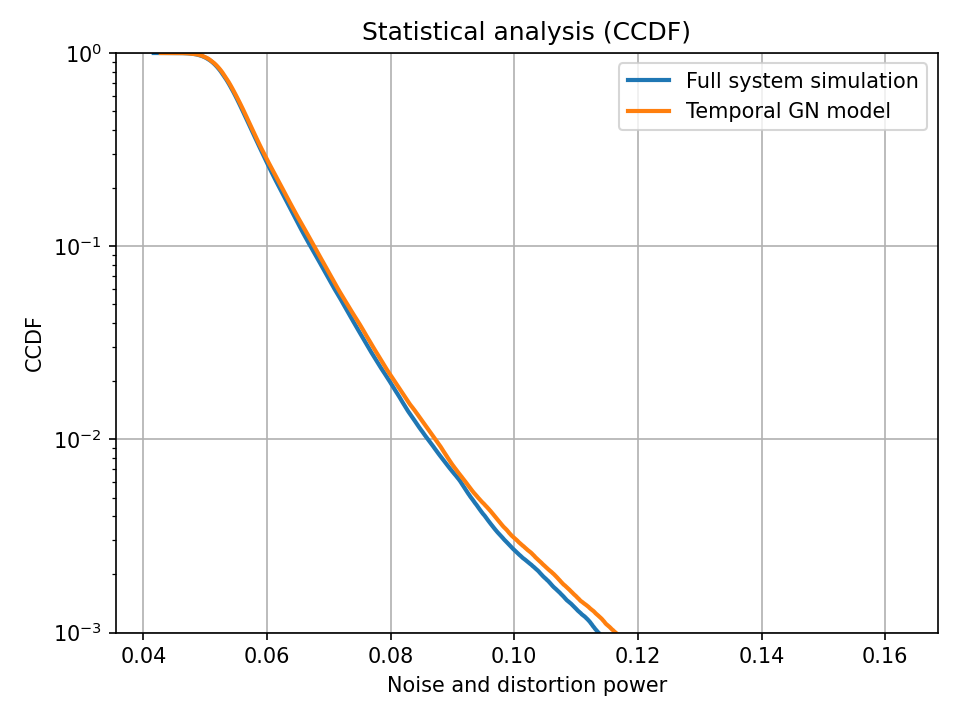

In [14]:
f_TGN, t_TGN = ecdf(sigma_TGN)
ccdf_vals_TGN = 1 - f_TGN

f_time, t_time = ecdf(sigma_time_varying)
ccdf_vals_time = 1 - f_time

f_sim, t_sim = ecdf(sigma_simulation)
ccdf_vals_sim = 1 - f_sim

try:
    plt.figure()
    plt.title("Statistical analysis (CCDF)")
    plt.semilogy(t_sim, ccdf_vals_sim, linewidth=2)
    plt.semilogy(t_TGN, ccdf_vals_TGN, linewidth=2)
    # plt.semilogy(t_time, ccdf_vals_time, linewidth=2)  # optional
    plt.legend(["Full system simulation","Temporal GN model"])
    plt.xlabel("Noise and distortion power"); plt.ylabel("CCDF")
    plt.ylim([1e-3, 1])
    plt.tight_layout()
    plt.grid()
except Exception as e:
    print("Plot skipped:", e)

##### Final comments
Note that this code slightly differs from the code used for the paper and the experiment. For example, we measure the phase noise realization in the paper. Further, the paper also includes experimental results, adaptive DSP, dual pol, etc...
If you should have any questions, comments, or remarks, please contact benedikt.geiger@kit.edu.
Written by Benedikt Geiger, September 2025.